In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
import time
from pydl85 import DL85Classifier
import pandas as pd
import numpy as np
import utils
import graphviz
import ast
from tqdm.notebook import tqdm
from multiprocessing import Process, Pool
from functools import partial
FILE_NAME = "census_income"

In [2]:
import load_data
X, y , sensitive = load_data.census()
print(utils.discrimination(y, sensitive))
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

sex                           b'Female'
workclass                          b'?'
education                       b'10th'
education-num                       1.0
marital-status              b'Divorced'
occupation                         b'?'
relationship                 b'Husband'
race              b'Amer-Indian-Eskimo'
age                                17.0
capital-gain                        0.0
capital-loss                        0.0
hours-per-week                      1.0
native-country                     b'?'
income_class                   b'<=50K'
dtype: object
0.19637403845538565


In [3]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=300)

    start = time.perf_counter()
    clf.fit(X_train, y_train)
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, utils.perf_measure(y_train, y_pred_train, sensitive_train), accuracy_pred, accuracy_test, sum_misclassified_train,
            discrimination_train,       sum_discrimination_additive_train,      sum_discrimination_additive_train_abs,
            discrimination_train_pred,  sum_discrimination_additive_train_pred, sum_discrimination_additive_train_pred_abs,
            discrimination_test,        sum_discrimination_additive_test_pred,  sum_discrimination_additive_test_pred_abs,
            duration, min_supp, clf.tree_]
        

pool = Pool()
if True:
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 5, 7, 15]:
        for k in [0, 3000, 5000, 10000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(91, 101, 5)):
        result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        
        
        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), tqdm(args)):
            result.loc[len(result.index)] = res


        #result = result.sort_values(['k', 'depth', 'min_supp'])
        result.to_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv', index=False)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [4]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"]) 
for random_state in tqdm(range(91, 101, 5)):
  result = pd.concat([result, pd.read_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv')])
  result.to_csv('save/'+FILE_NAME+'.csv', index=False)
result

  0%|          | 0/2 [00:00<?, ?it/s]

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,sum_discrimination_additive_train_abs,discrimination_train_pred,sum_discrimination_additive_train_pred,sum_discrimination_additive_train_pred_abs,discrimination_test,sum_discrimination_additive_test_pred,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,91,2761.0,0.770833,"((167, 0, 2343, 5608), (17, 2, 416, 3495))",0.770833,0.766268,2761,0.199011,...,0.199011,0.015737,0.015737,0.015737,0.016011,0.016011,0.016011,0.390656,2,"{'feat': 103, 'left': {'value': 1, 'error': 2,..."
1,3000,1,91,2808.210938,0.766915,"((167, 0, 2343, 5608), (17, 2, 416, 3495))",0.770833,0.766268,2761,0.199011,...,0.199011,0.015737,0.015737,0.015737,0.016011,0.016011,0.016011,0.345836,2,"{'feat': 103, 'left': {'value': 1, 'error': 49..."
2,5000,1,91,2839.684814,0.764302,"((167, 0, 2343, 5608), (17, 2, 416, 3495))",0.770833,0.766268,2761,0.199011,...,0.199011,0.015737,0.015737,0.015737,0.016011,0.016011,0.016011,0.424786,2,"{'feat': 103, 'left': {'value': 1, 'error': 80..."
3,10000,1,91,2917.919922,0.757809,"((60, 0, 2450, 5608), (11, 0, 422, 3497))",0.76162,0.751992,2872,0.199011,...,0.199011,0.004592,0.004592,0.004592,0.001908,0.001908,0.001908,0.352066,2,"{'feat': 122, 'left': {'value': 1, 'error': 45..."
4,100000,1,91,2935.274902,0.756368,"((11, 0, 2499, 5608), (5, 0, 428, 3497))",0.757055,0.750332,2927,0.199011,...,0.199011,0.000083,0.000083,0.000083,-0.000556,-0.000556,0.000556,0.388334,2,"{'feat': 106, 'left': {'value': 1, 'error': 8...."
5,0,2,91,2439.0,0.79756,"((744, 283, 1766, 5325), (87, 44, 346, 3453))",0.79756,0.792165,2439,0.199011,...,0.211282,0.093176,0.093176,0.093176,0.095367,0.095367,0.095367,22.753889,2,"{'feat': 14, 'left': {'feat': 22, 'left': {'va..."
6,3000,2,91,2691.761719,0.77658,"((621, 218, 1889, 5390), (95, 39, 338, 3458))",0.793825,0.794489,2484,0.199011,...,0.211593,0.069254,0.069254,0.069254,0.054397,0.054397,0.054397,25.888011,2,"{'feat': 35, 'left': {'feat': 22, 'left': {'va..."
7,5000,2,91,2764.855713,0.770513,"((279, 0, 2231, 5608), (31, 2, 402, 3495))",0.781292,0.777888,2635,0.199011,...,0.199011,0.025971,0.025971,0.025971,0.025711,0.025711,0.025711,26.275107,2,"{'feat': 103, 'left': {'feat': 1, 'left': {'va..."
8,10000,2,91,2877.627197,0.761153,"((316, 150, 2194, 5458), (76, 134, 357, 3363))",0.764691,0.76328,2835,0.199011,...,0.199011,0.003968,0.003968,0.004263,0.009788,0.009788,0.009788,24.745541,2,"{'feat': 17, 'left': {'feat': 48, 'left': {'va..."
9,100000,2,91,2901.960205,0.759133,"((272, 150, 2238, 5458), (71, 134, 362, 3363))",0.760624,0.761288,2884,0.199011,...,0.199076,-0.00018,-0.00018,0.00018,0.008341,0.008341,0.008404,26.903809,2,"{'feat': 17, 'left': {'feat': 48, 'left': {'va..."


# Graphs

<Figure size 648x432 with 0 Axes>

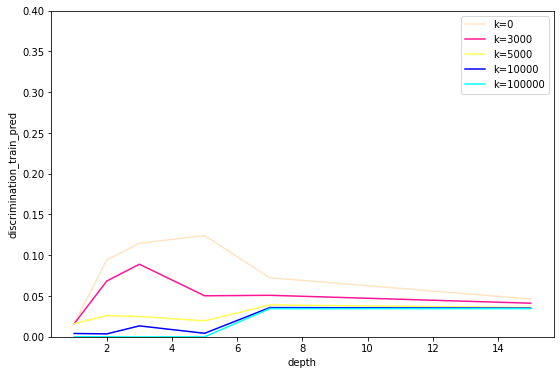

In [5]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

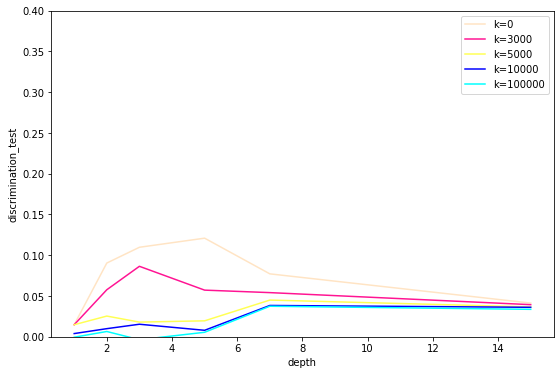

In [6]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

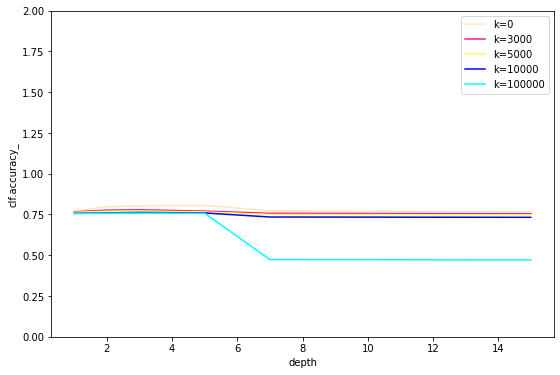

In [7]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

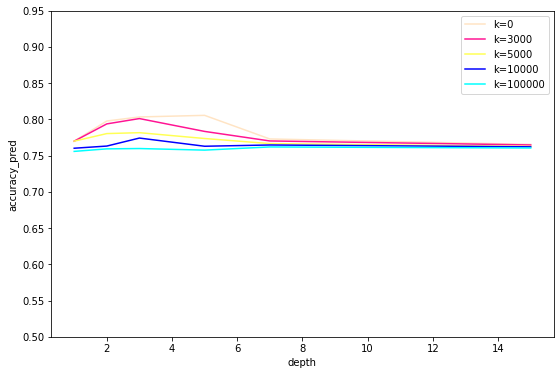

In [8]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95)

<Figure size 648x432 with 0 Axes>

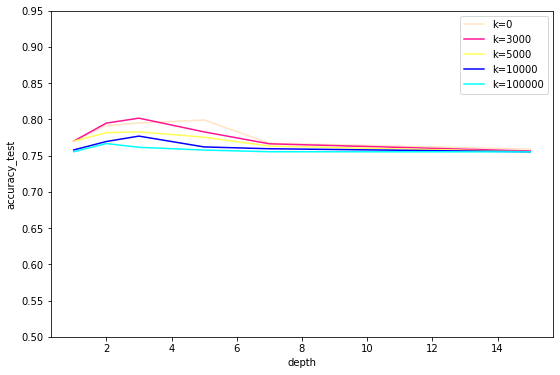

In [9]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95)

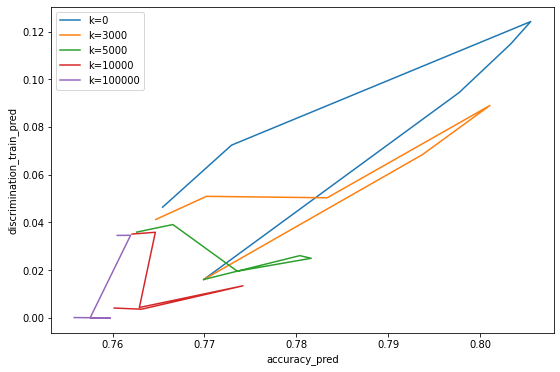

In [10]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

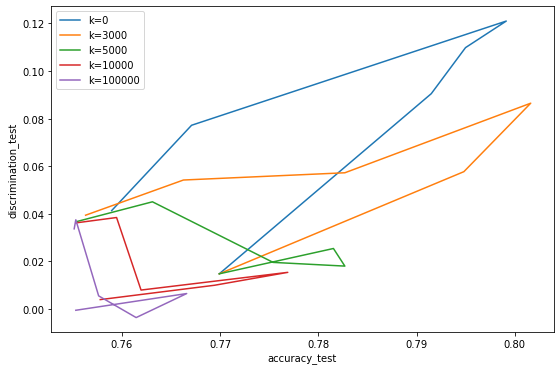

In [11]:
utils.plot2("accuracy_test", "discrimination_test", result)

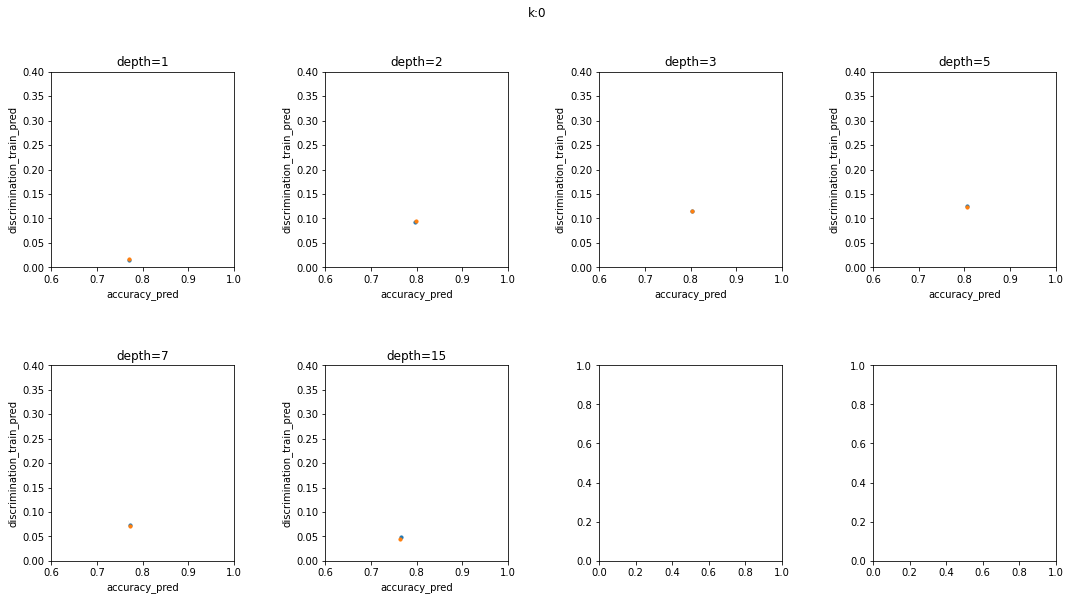

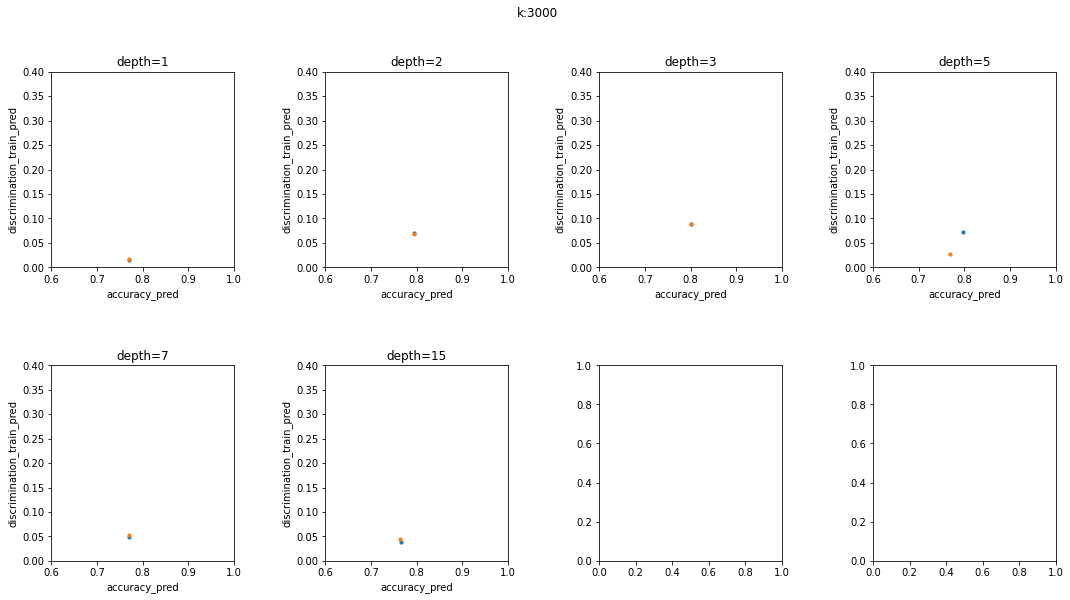

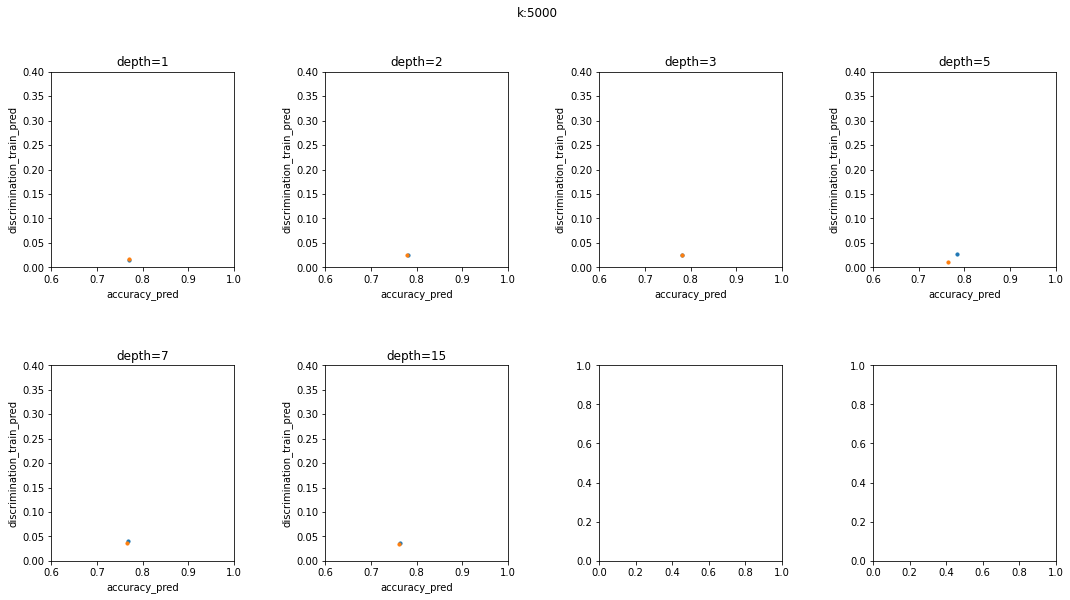

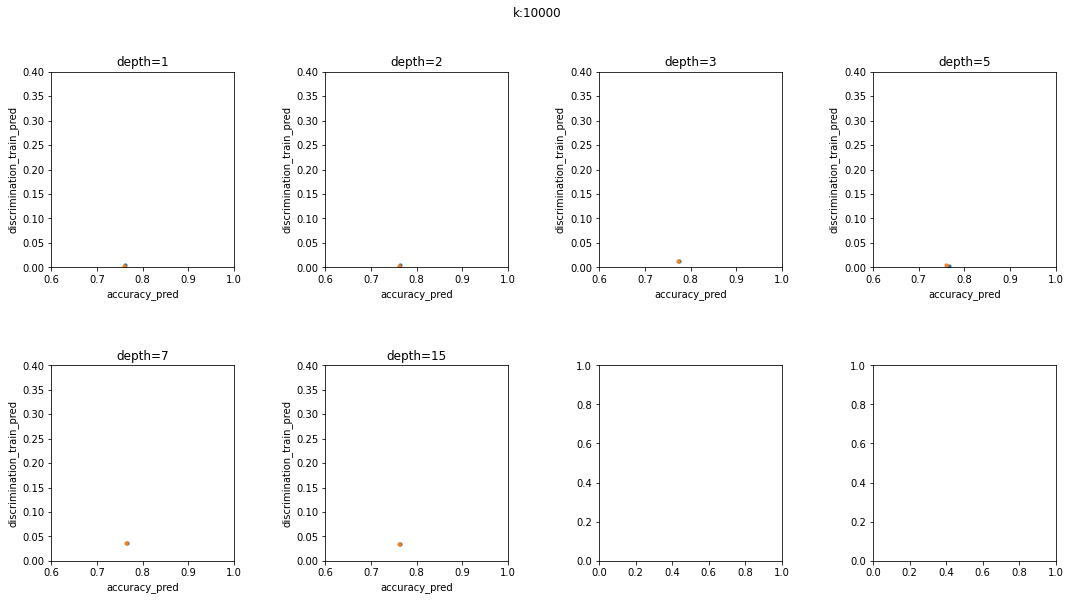

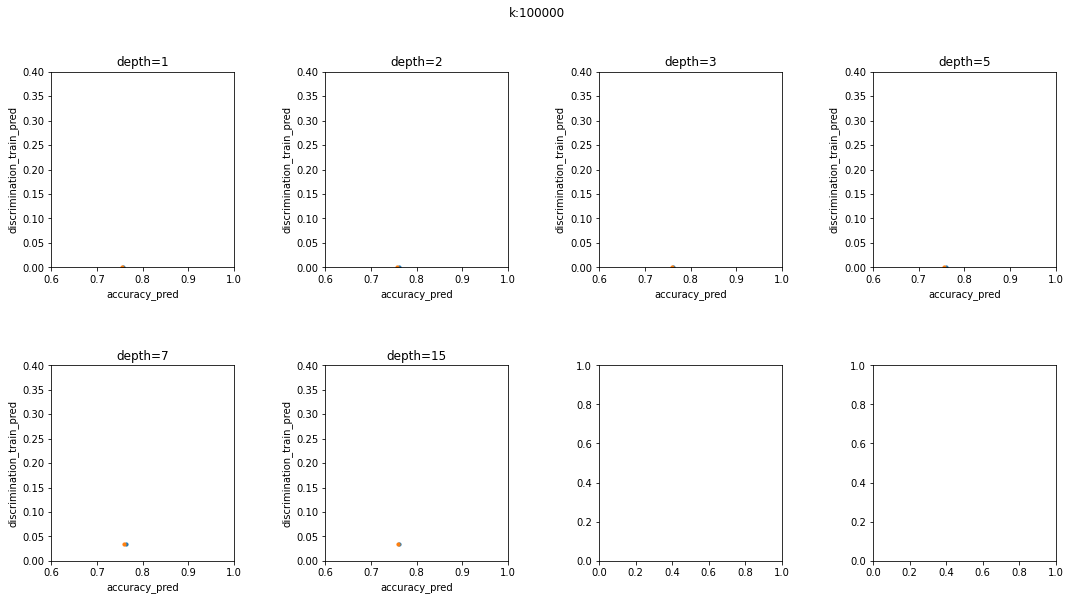

In [12]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

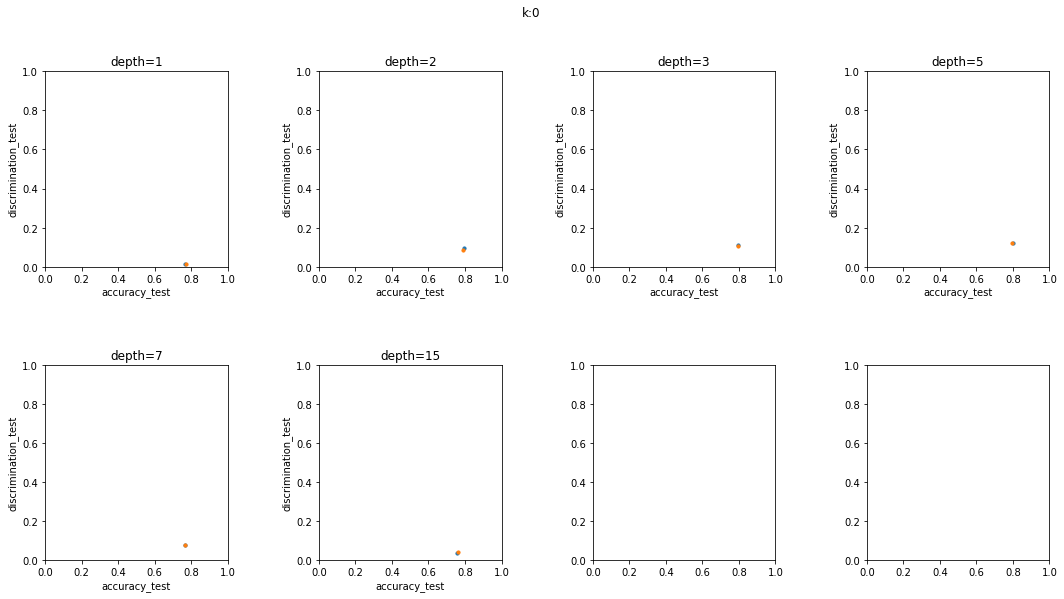

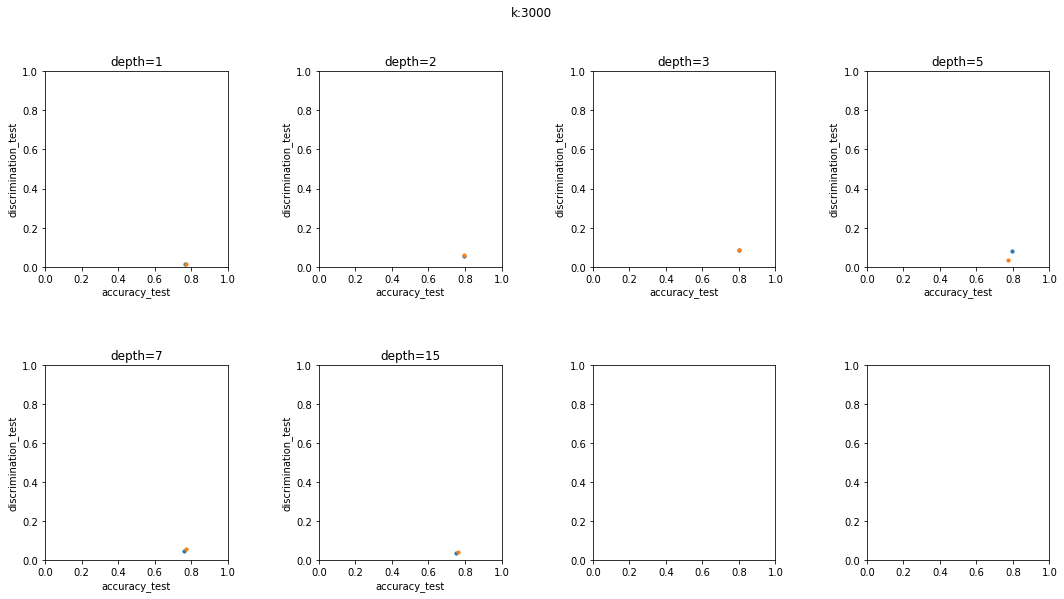

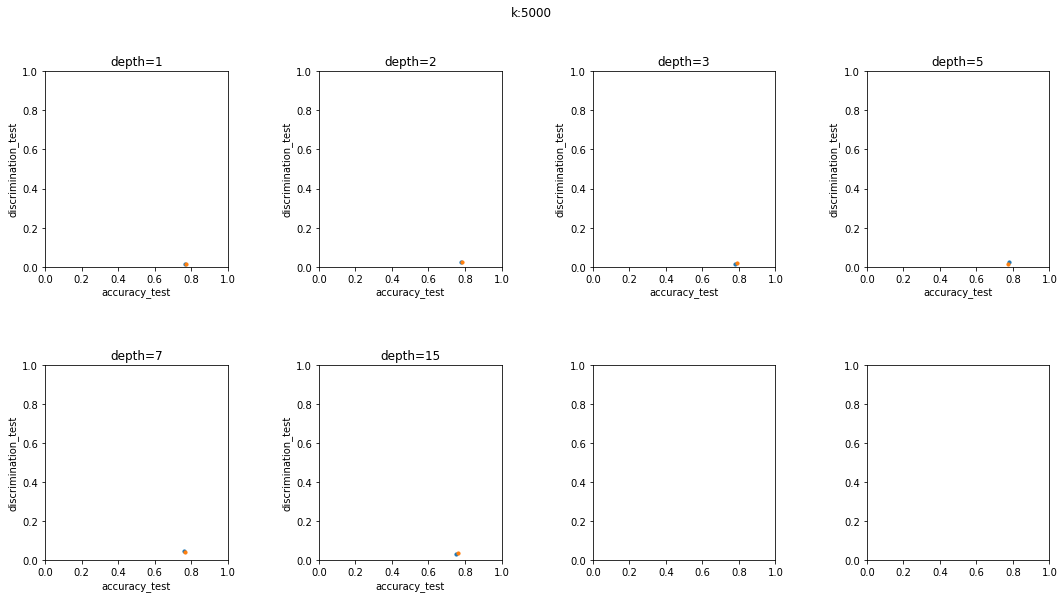

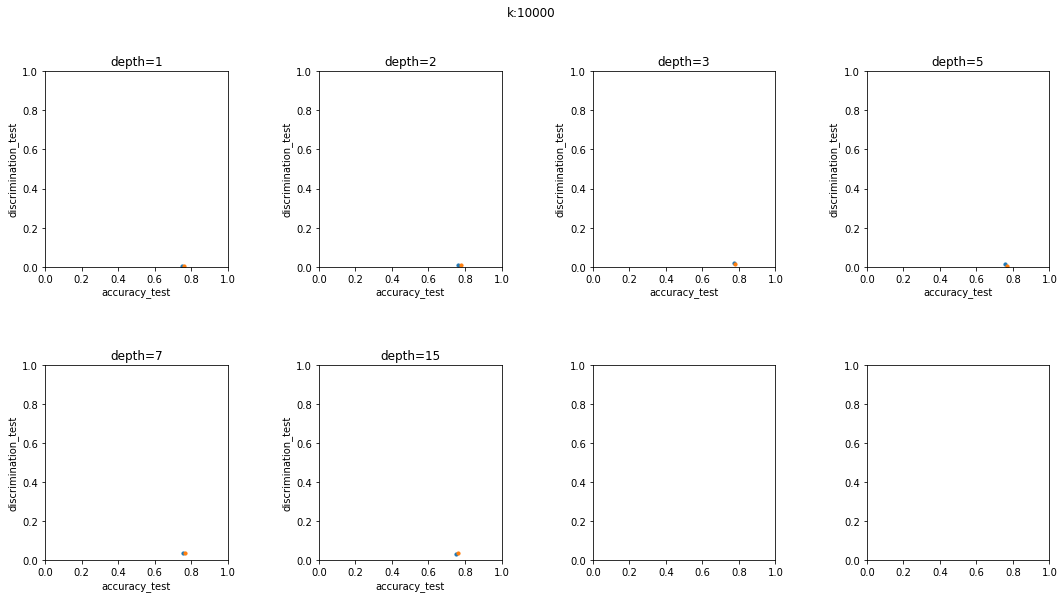

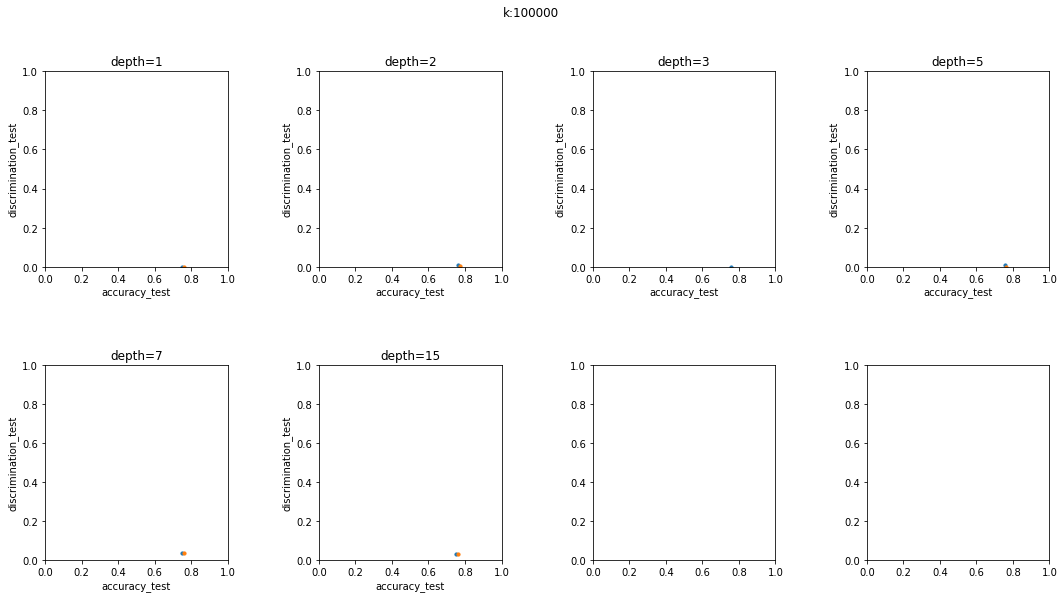

In [13]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

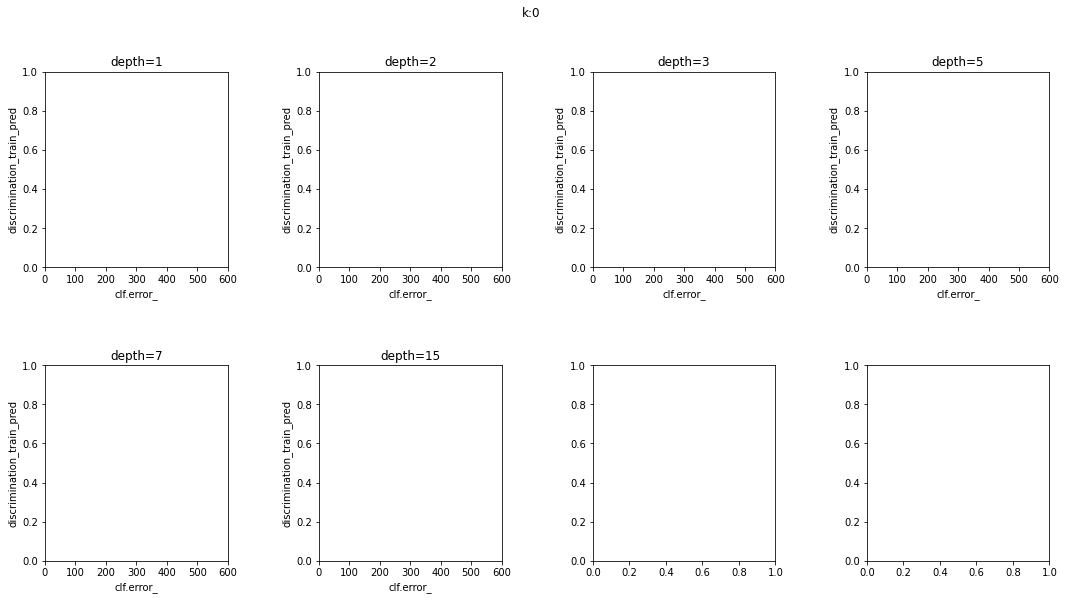

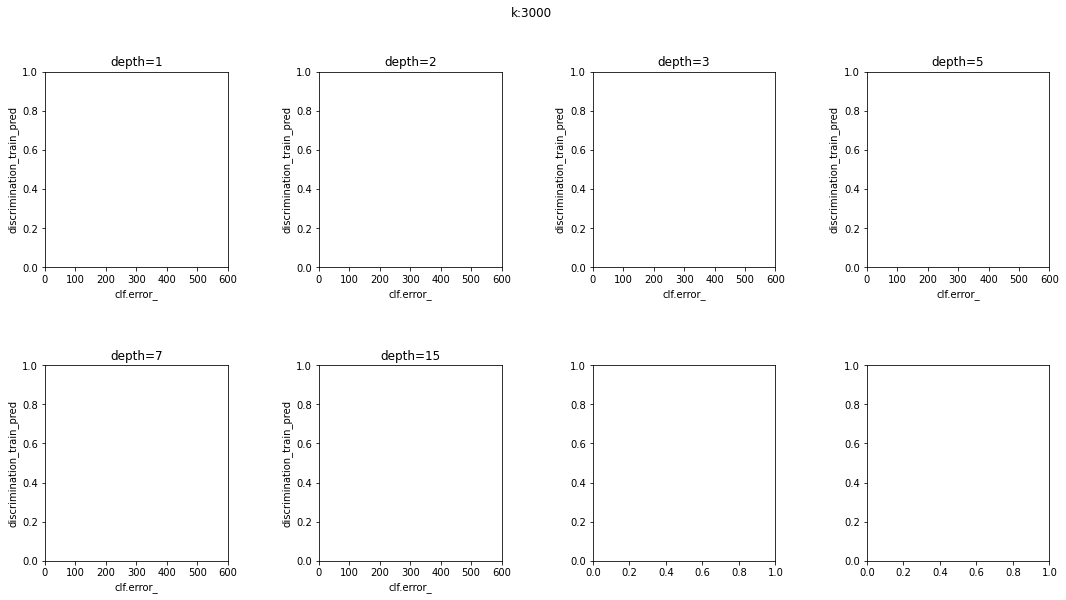

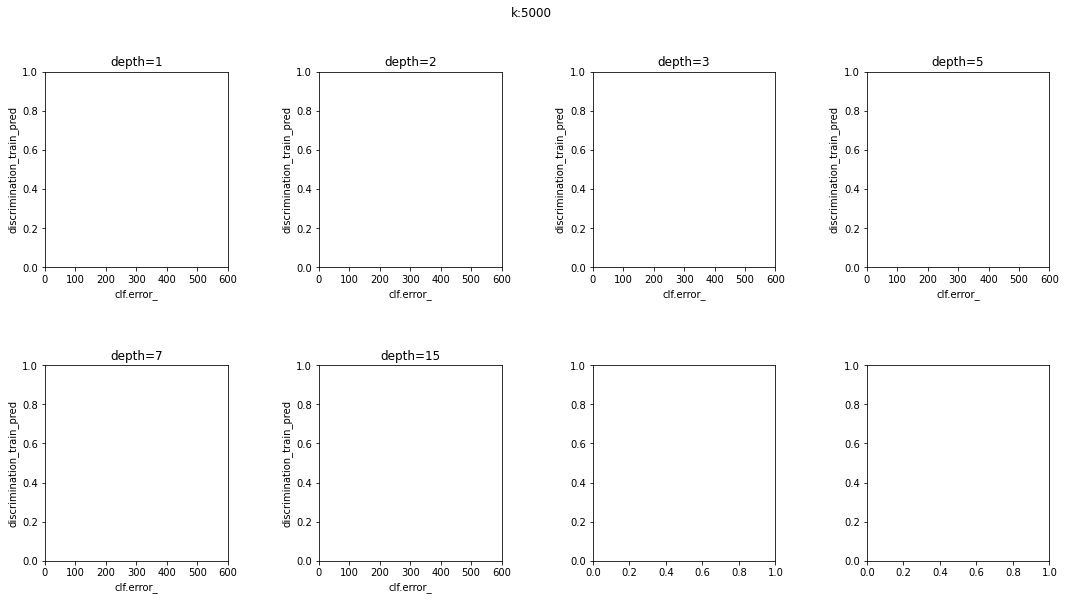

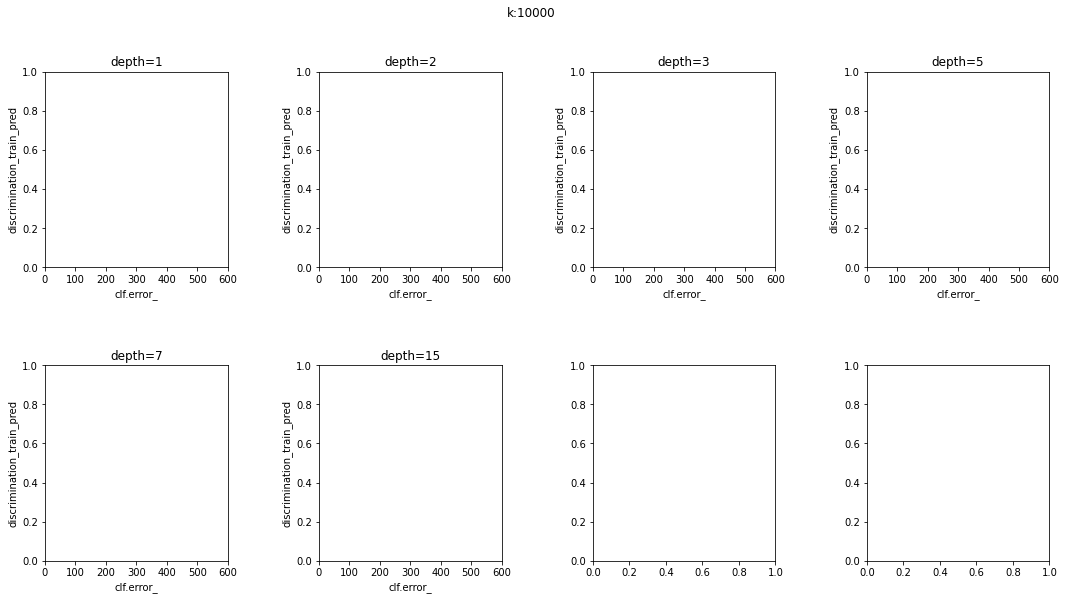

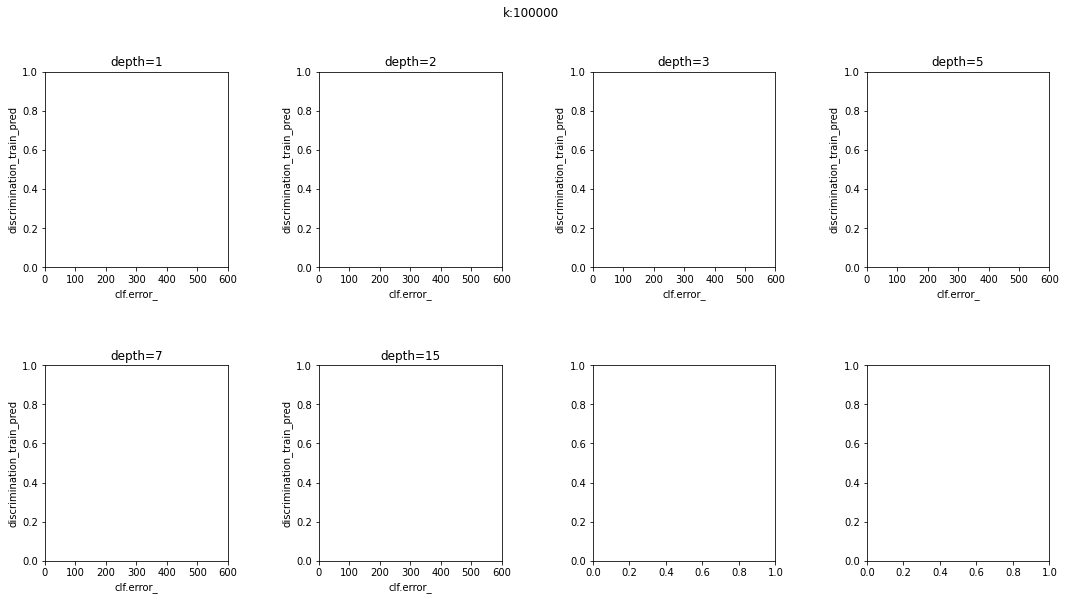

In [14]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

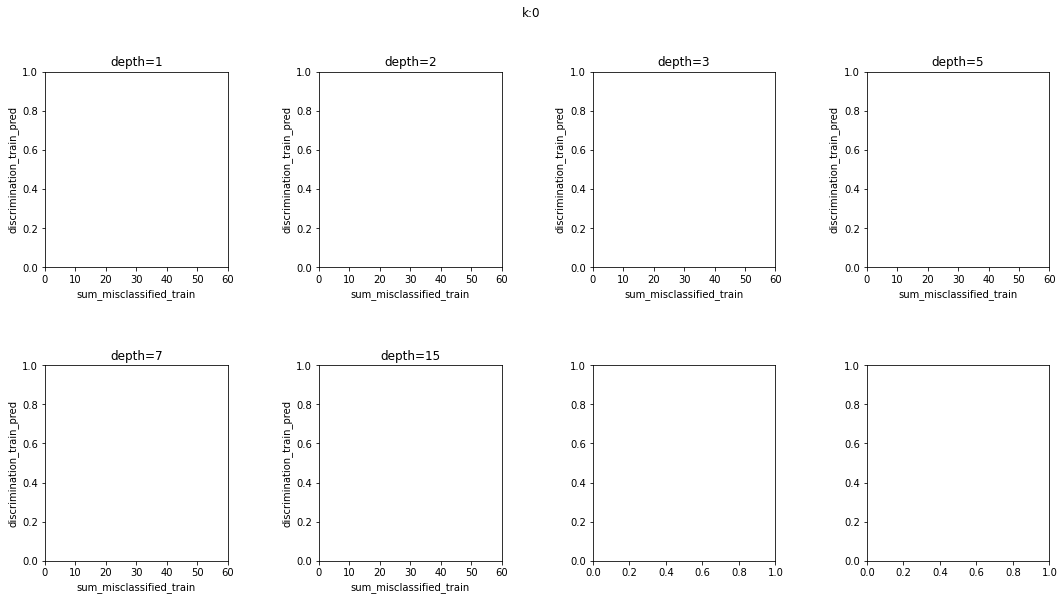

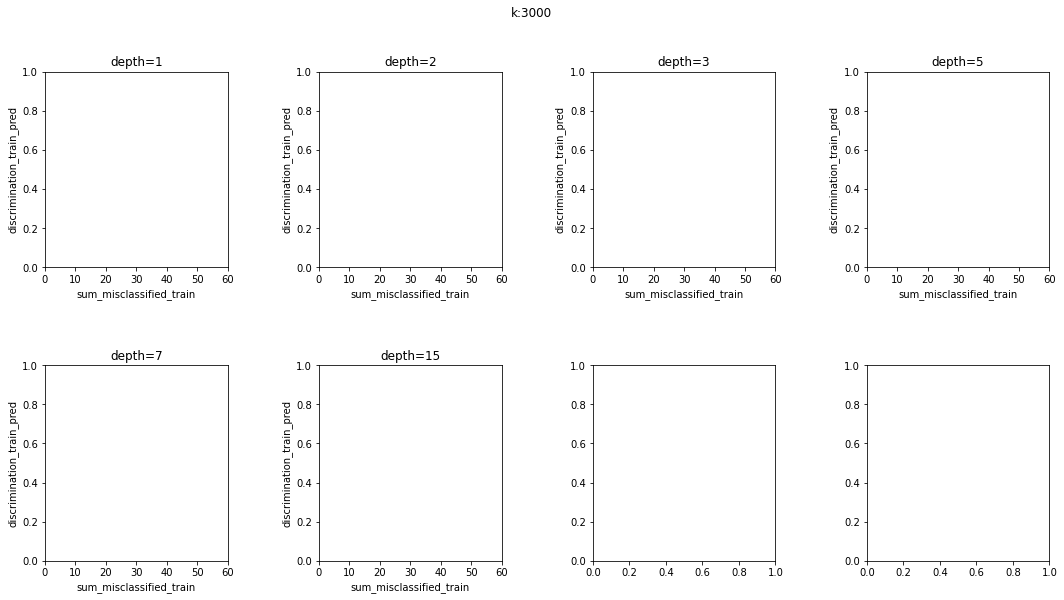

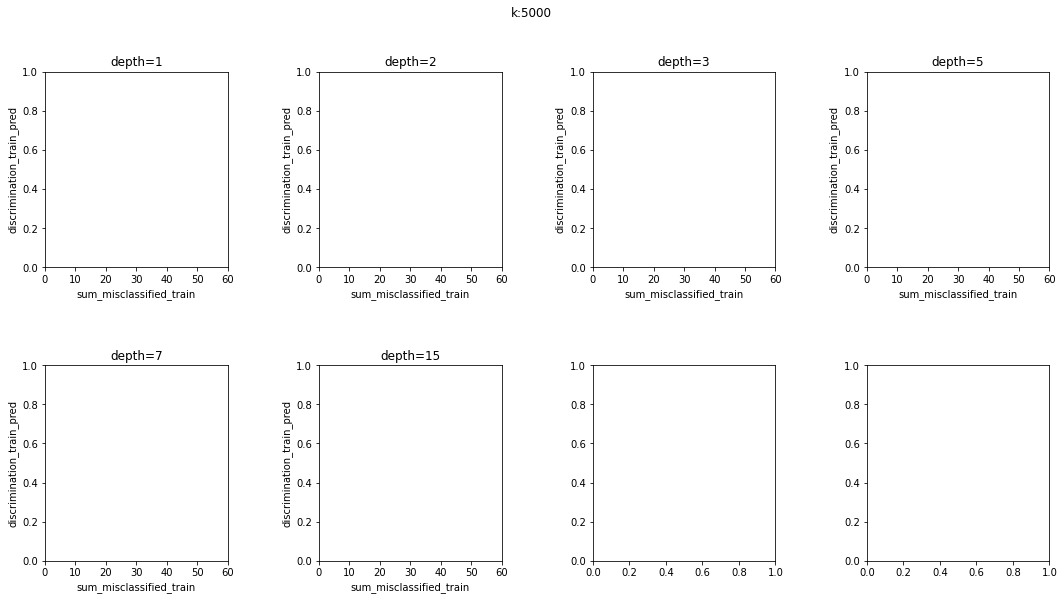

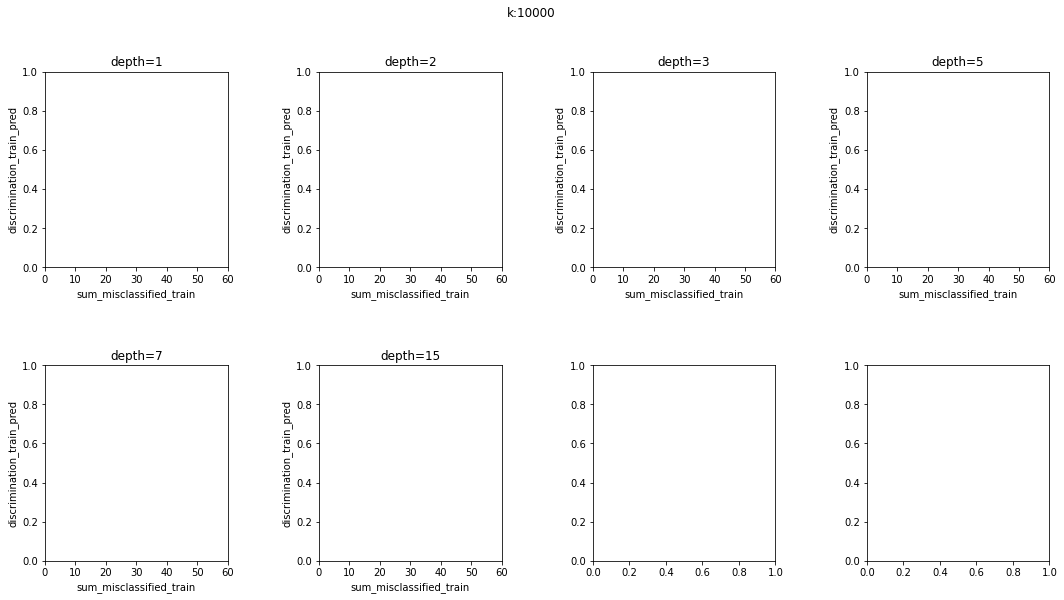

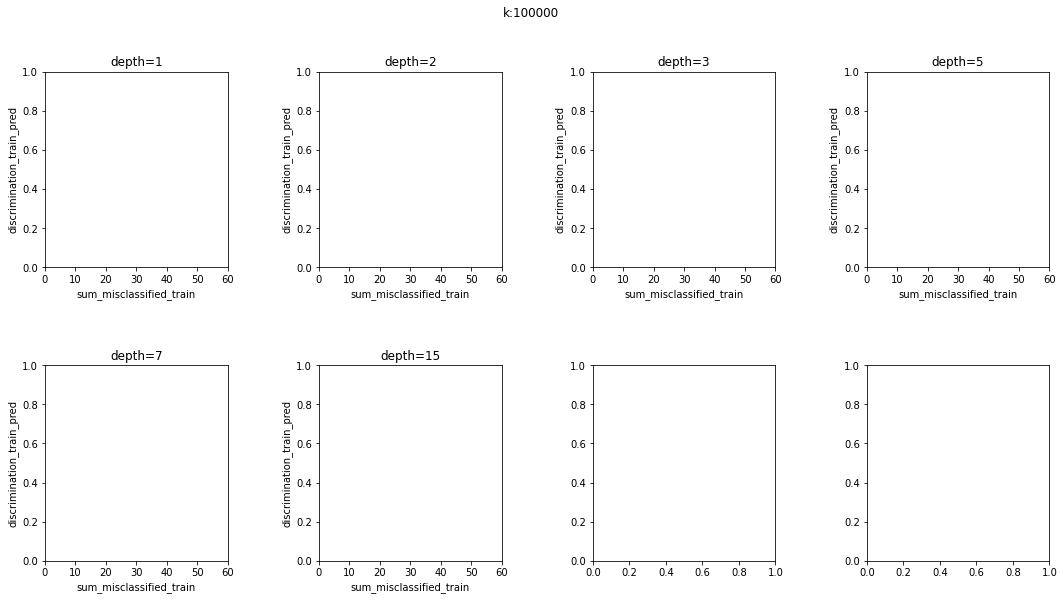

In [15]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

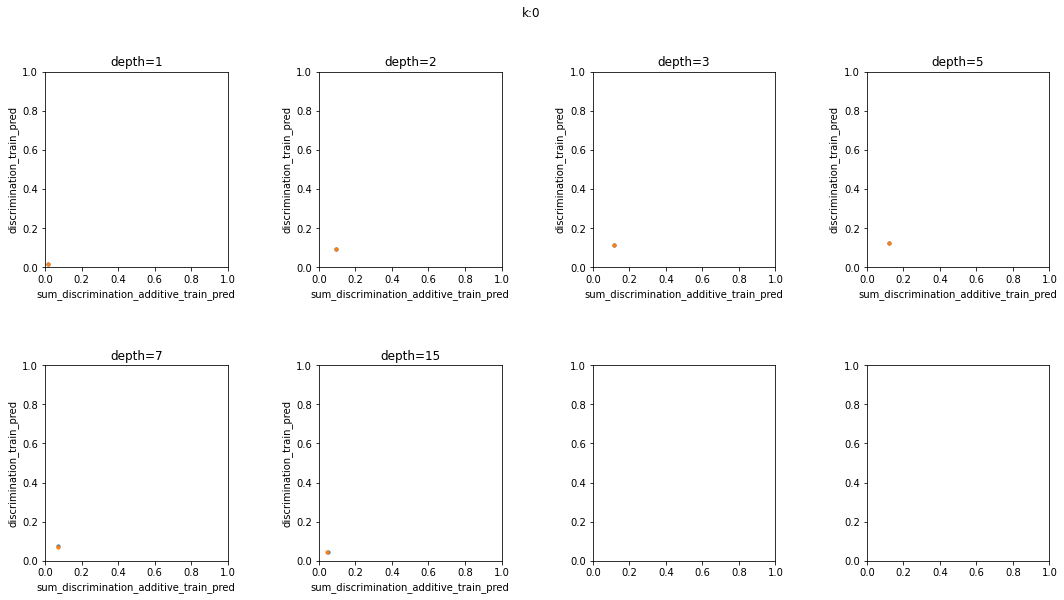

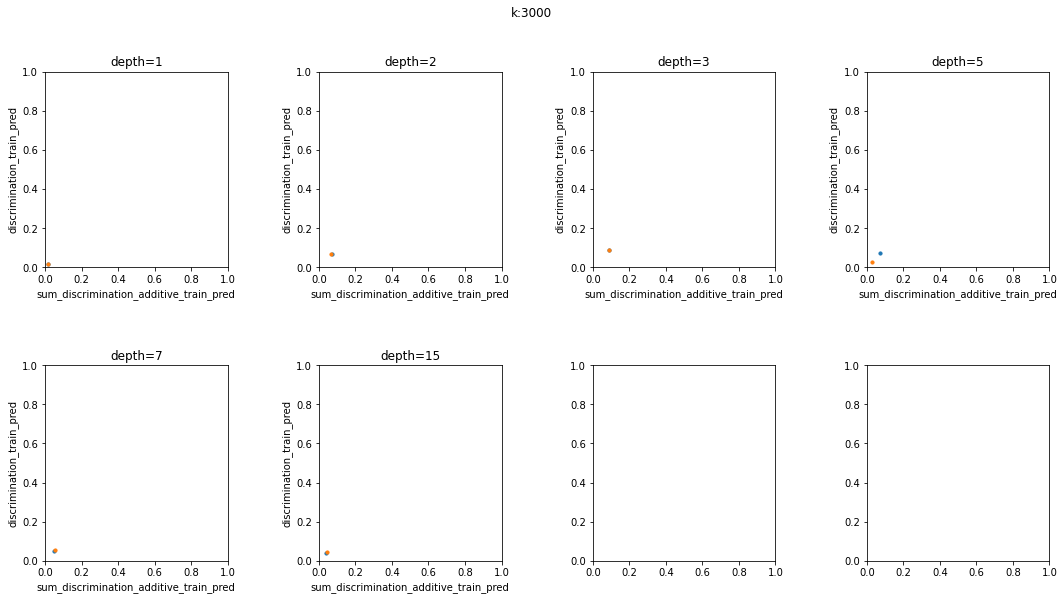

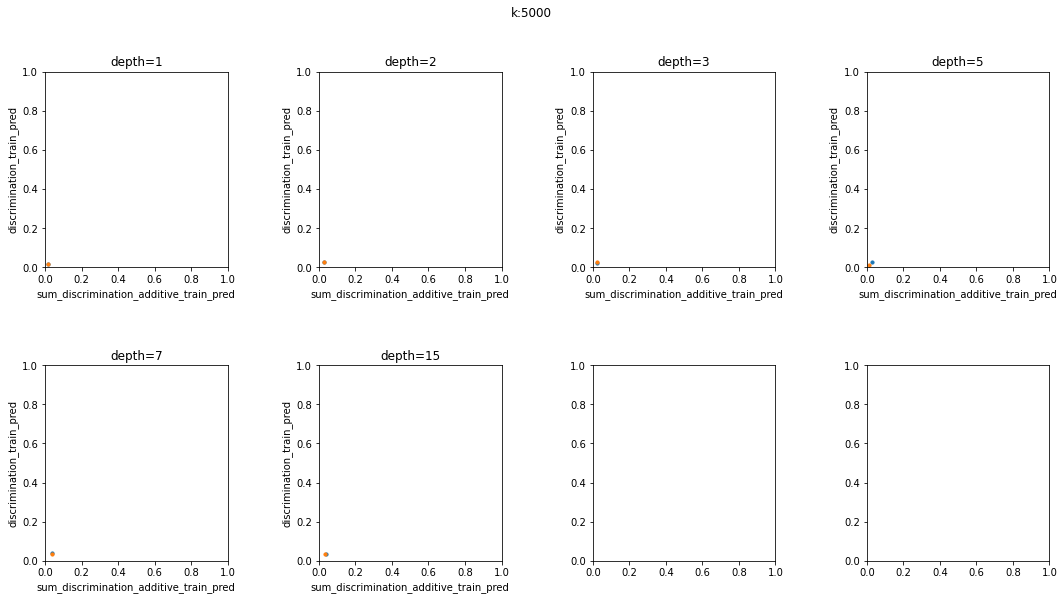

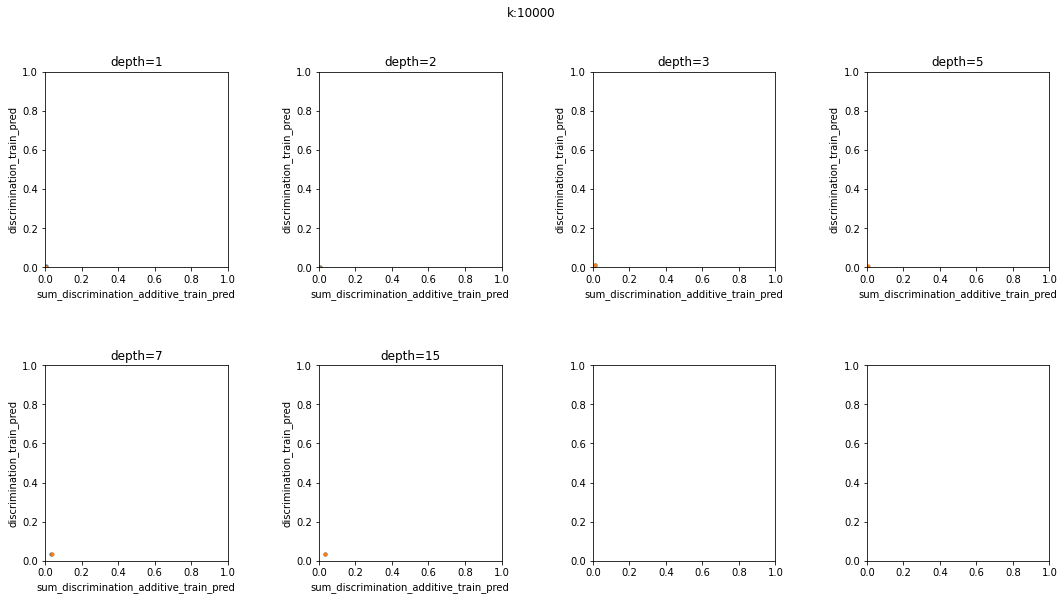

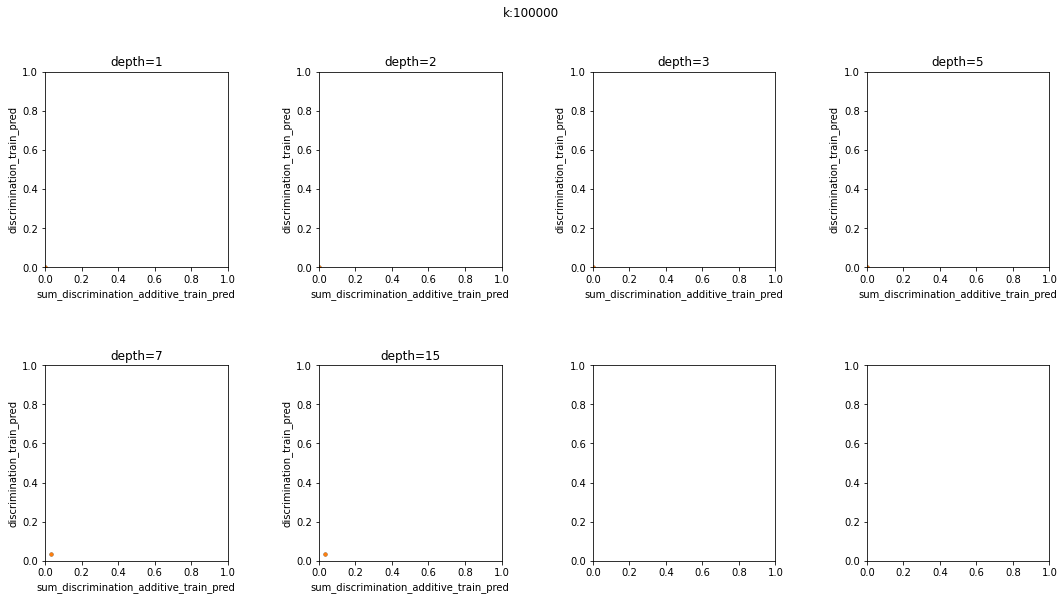

In [16]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

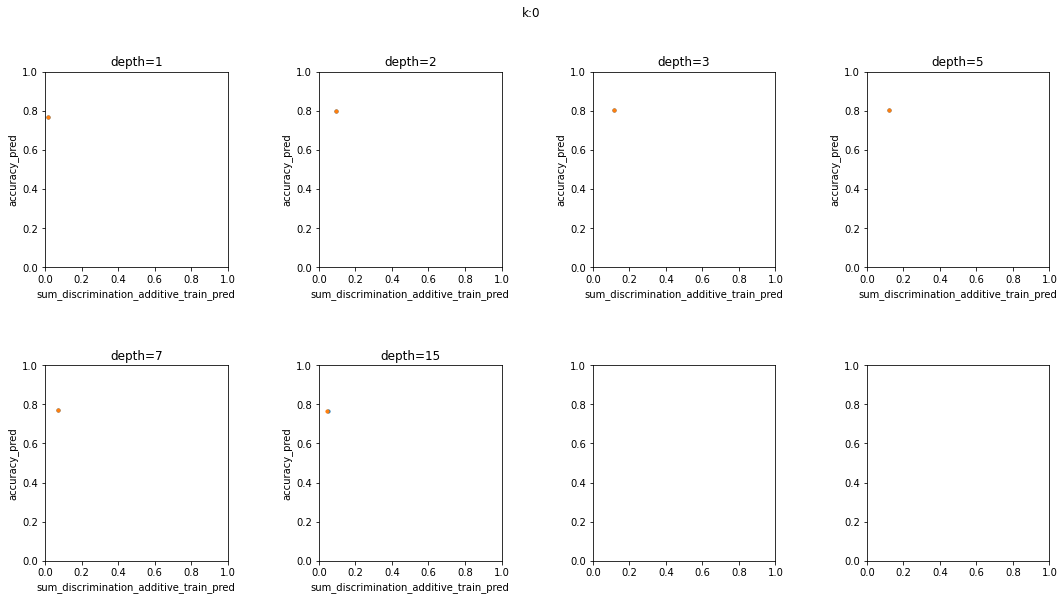

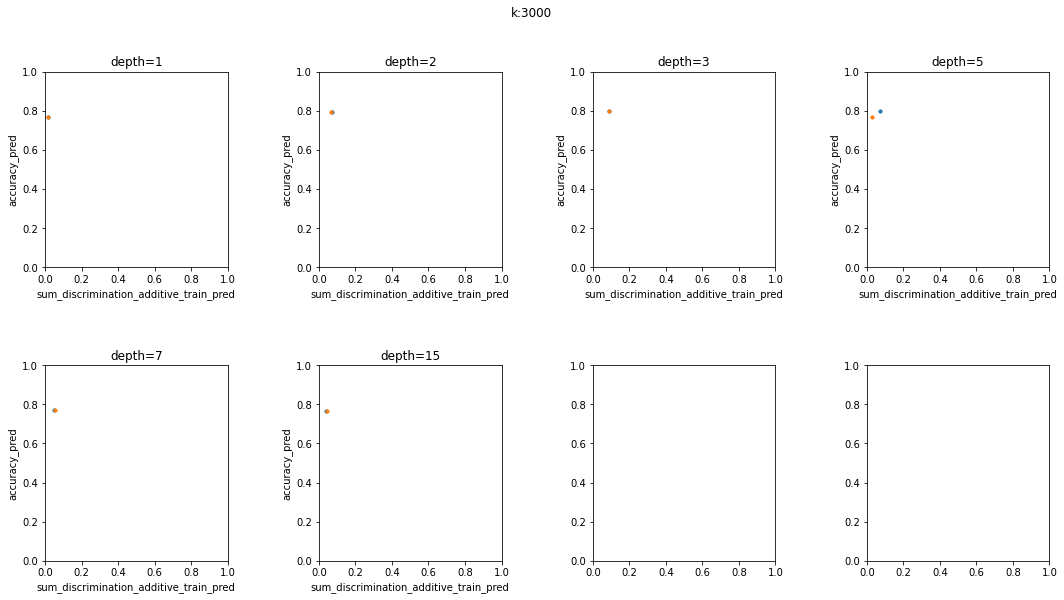

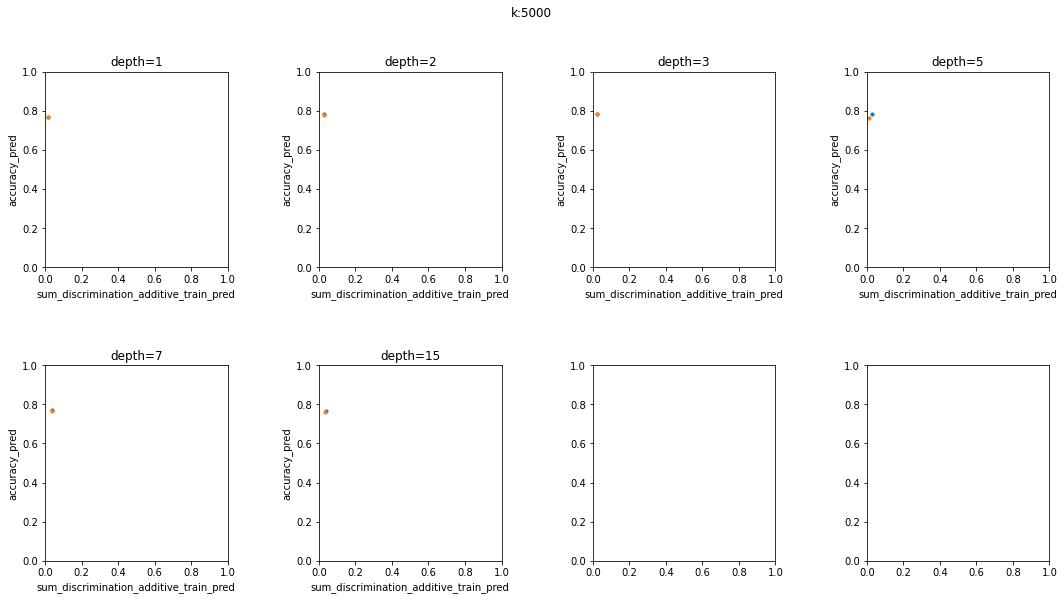

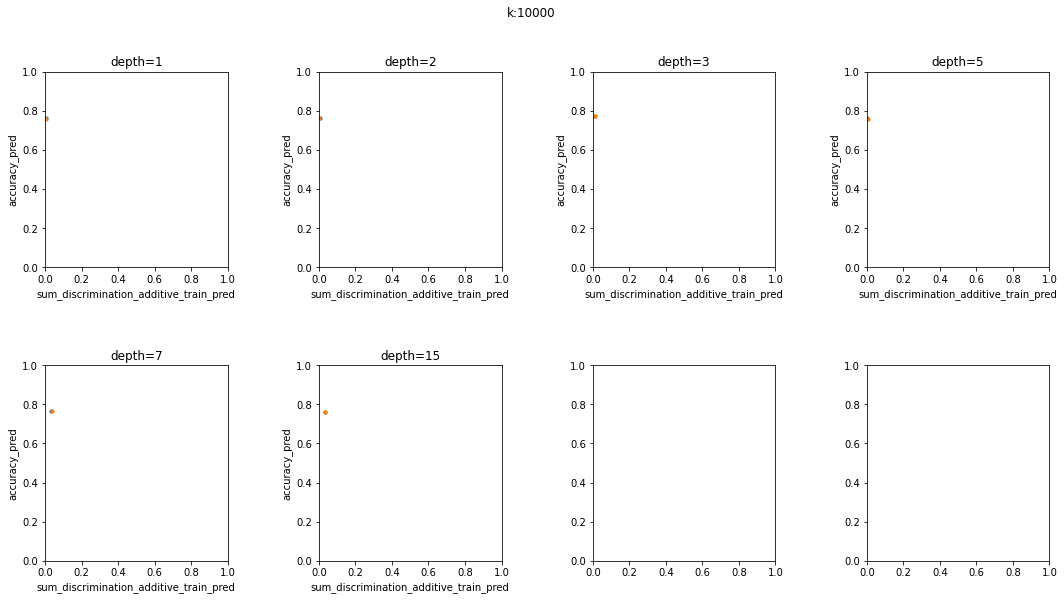

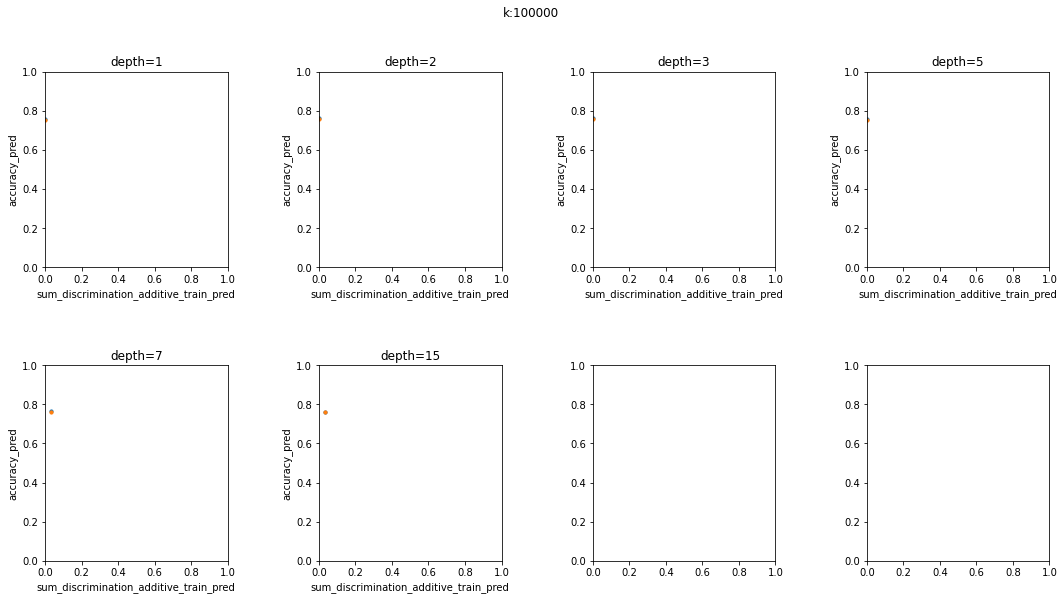

In [17]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

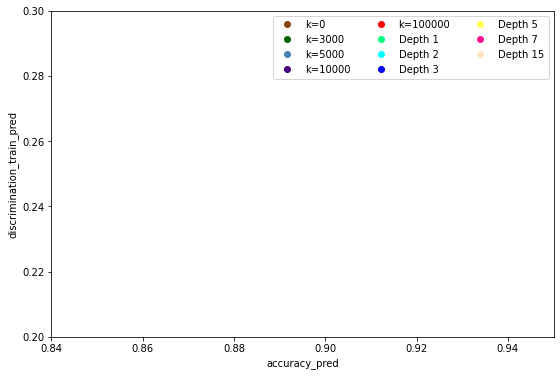

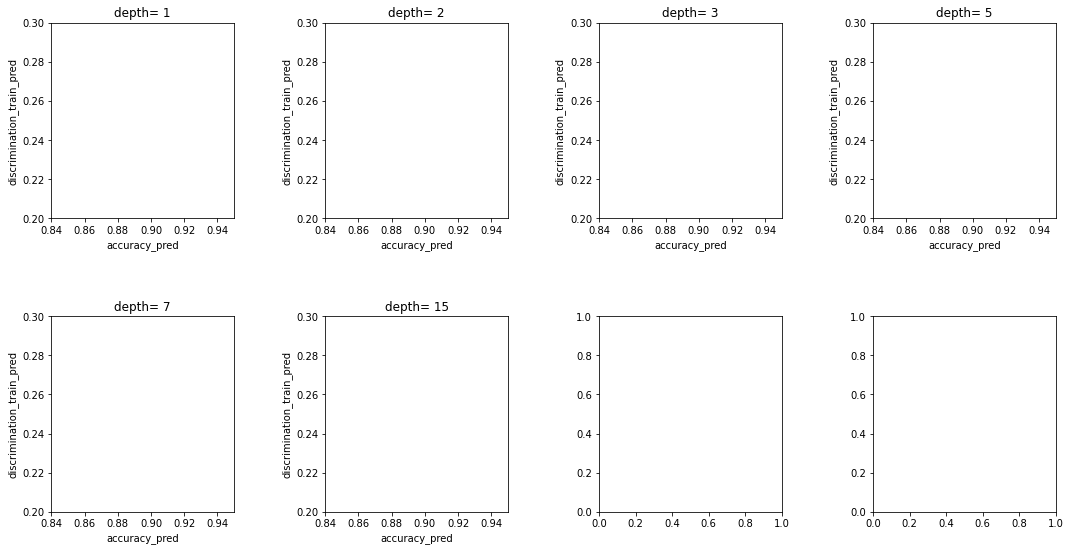

In [18]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

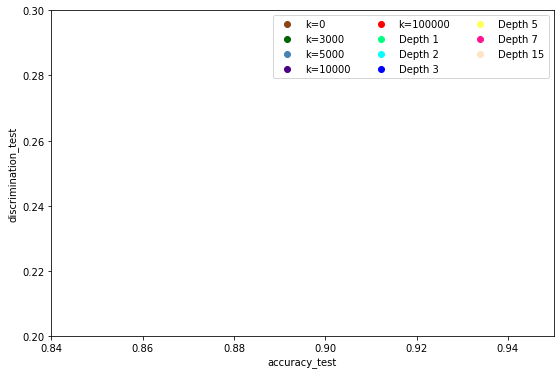

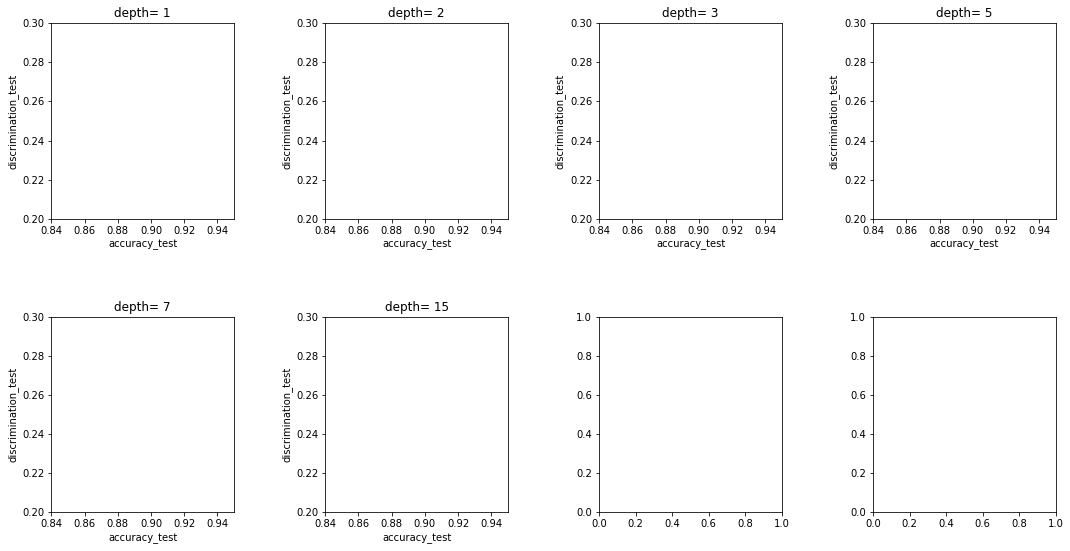

In [19]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

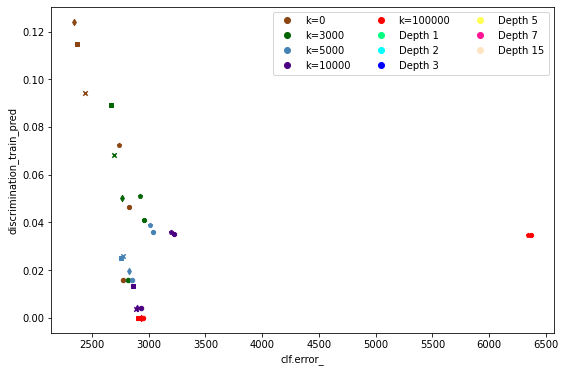

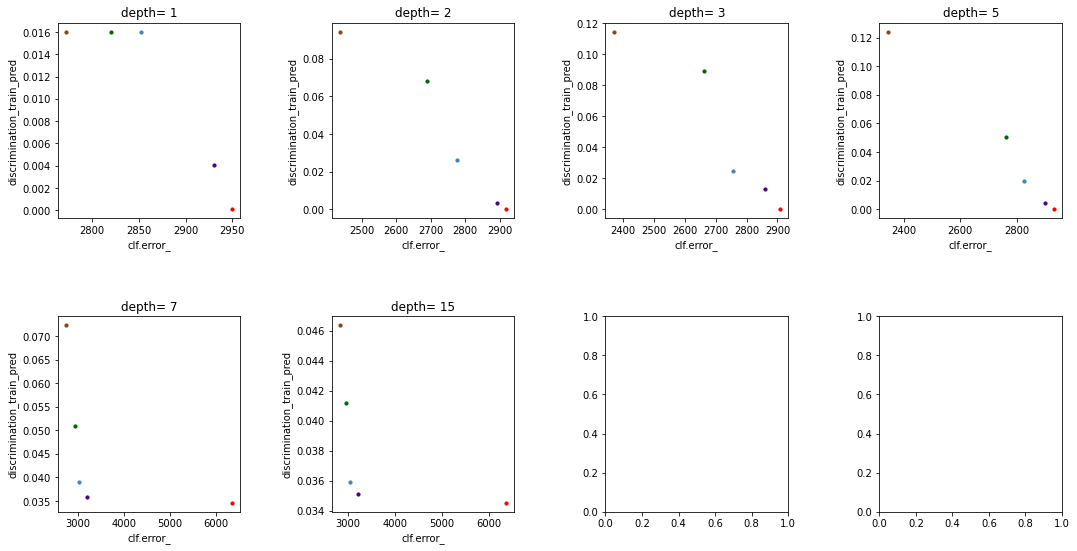

In [20]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

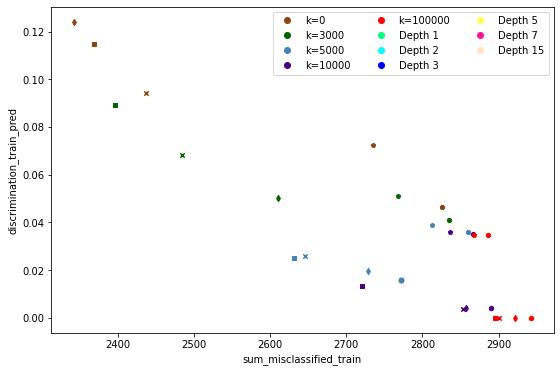

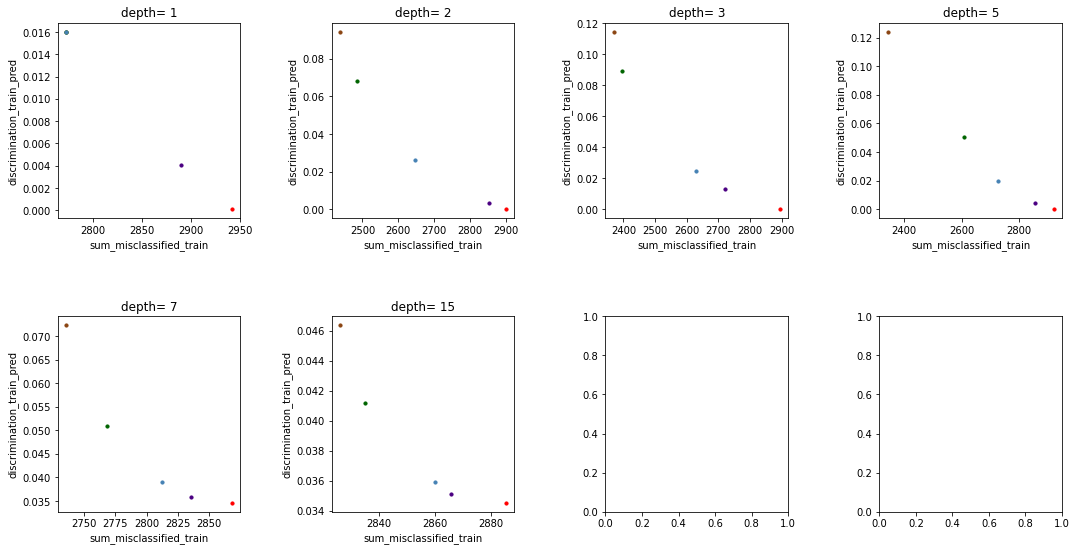

In [21]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

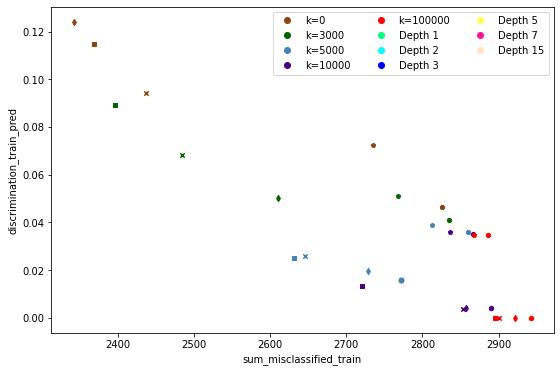

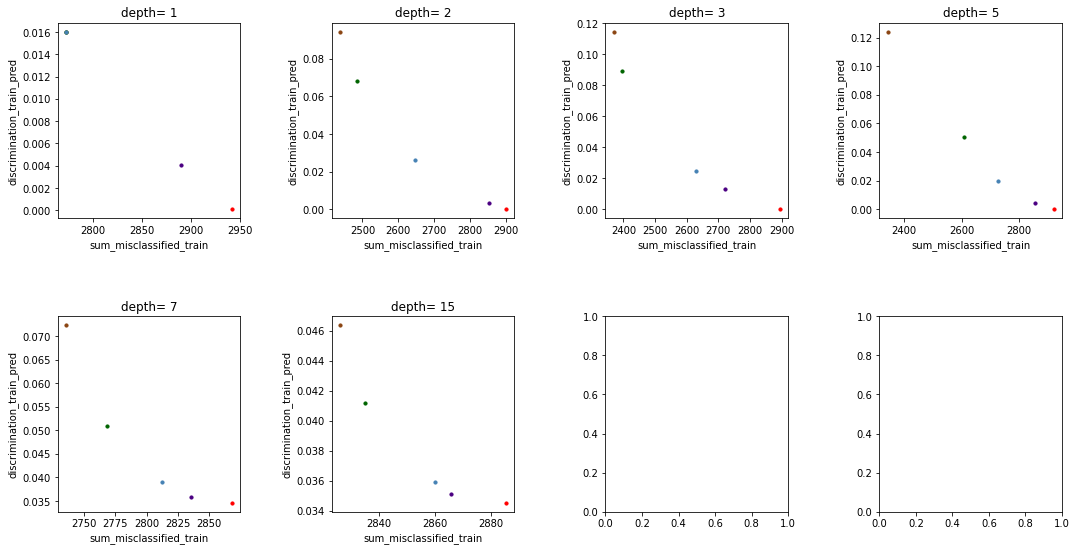

In [22]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

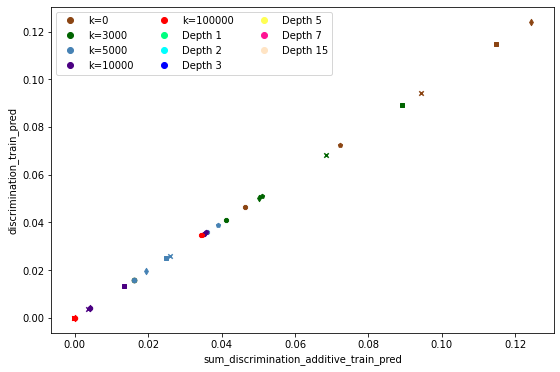

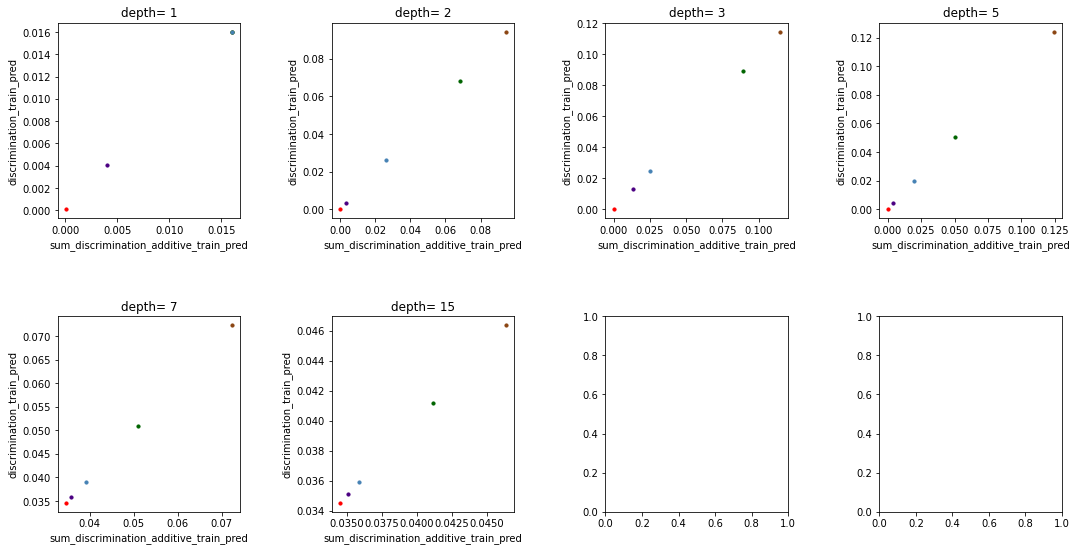

In [23]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

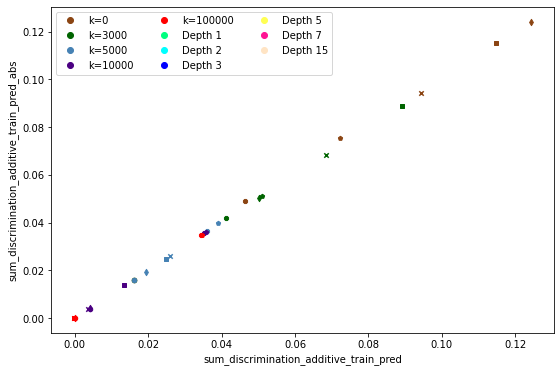

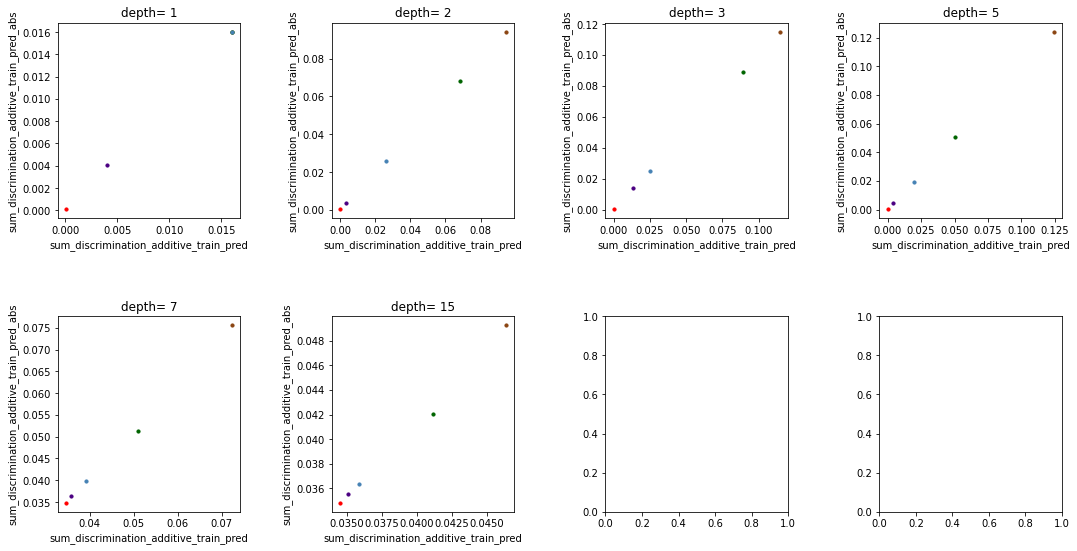

In [24]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)